In [ ]:
!pip install wrds
!pip install cvxpy
!pip install ecos
!pip install tdqm

In [1]:
# Import necessary modules
import cvxpy as cp
import wrds
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from scipy import stats
import warnings
import os
import traceback
from tqdm import tqdm
from sklearn.covariance import LedoitWolf
import time

# Ignore warnings
warnings.filterwarnings('ignore')

Minimum Variance Portfolio Optimization with Rolling Window Backtest

Minimum Variance Portfolio Optimization Inputs

Connecting to WRDS...
Attempting WRDS connection (attempt 1/3)...
WRDS recommends setting up a .pgpass file.
pgpass file created at C:\Users\javed\AppData\Roaming\postgresql\pgpass.conf
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done
WRDS connection successful

Backtest Period:

Stock Selection:
Enter tickers (space-separated) or press Enter for default 20 blue chips:
Using default 20 blue chip tickers

Portfolio Constraints:

Risk-Free Rate:

Data Quality Requirements:

Output Options:
Please enter 'y' for yes or 'n' for no

Configuration Summary:
Assets: 20 stocks
Period: 2010-2024
Estimation window: 36 months
Weight range: [-1.00, 1.00]
Short selling: Allowed
Fetching data for 20 assets (2010-2024)...
Data validation: All tickers have sufficient data
Running backtest

Processing periods: 100%|██████████| 132/132 [00:01<00:00, 82.32it/s]


Analyzing results...

PERFORMANCE RESULTS
                      Sample Covariance Ledoit-Wolf
Total Return                    315.79%     242.30%
Annualized Return                13.83%      11.84%
Annualized Volatility            18.67%      14.03%
Sharpe Ratio                      0.570       0.576
Sortino Ratio                     0.777       0.930
Maximum Drawdown                -30.88%     -19.20%
Win Rate                          64.4%       59.8%
Best Month                       15.36%      11.76%
Worst Month                     -18.99%      -9.78%
Skewness                         -0.232       0.168
Kurtosis                          1.135       0.409

PORTFOLIO WEIGHTS (FINAL PERIOD)

SAMPLE COVARIANCE              LEDOIT-WOLF
-----------------------------------------------------------------
JPM: 0.509 (Long)              GOOG: 0.200 (Long)
PG: -0.457 (Short)             JNJ: 0.185 (Long)
WMT: 0.447 (Long)              WMT: 0.181 (Long)
GS: -0.399 (Short)             CAT: -0.180

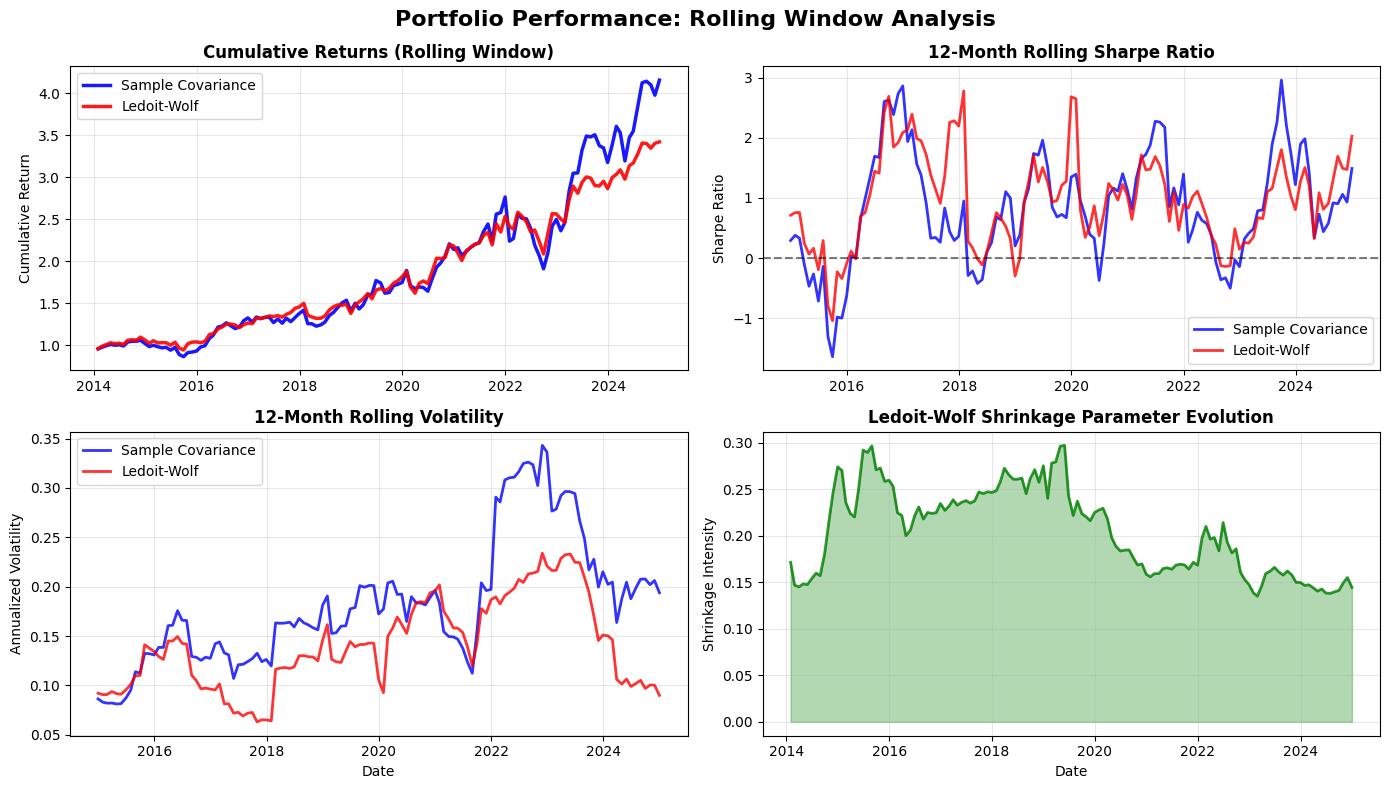

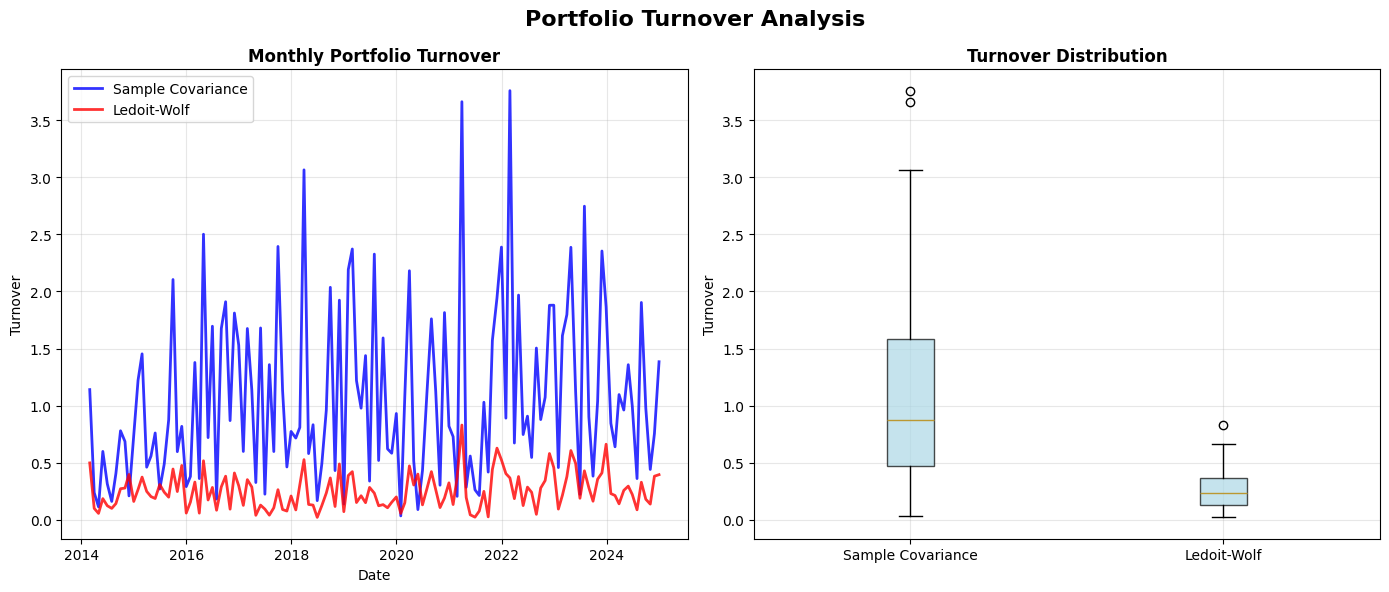

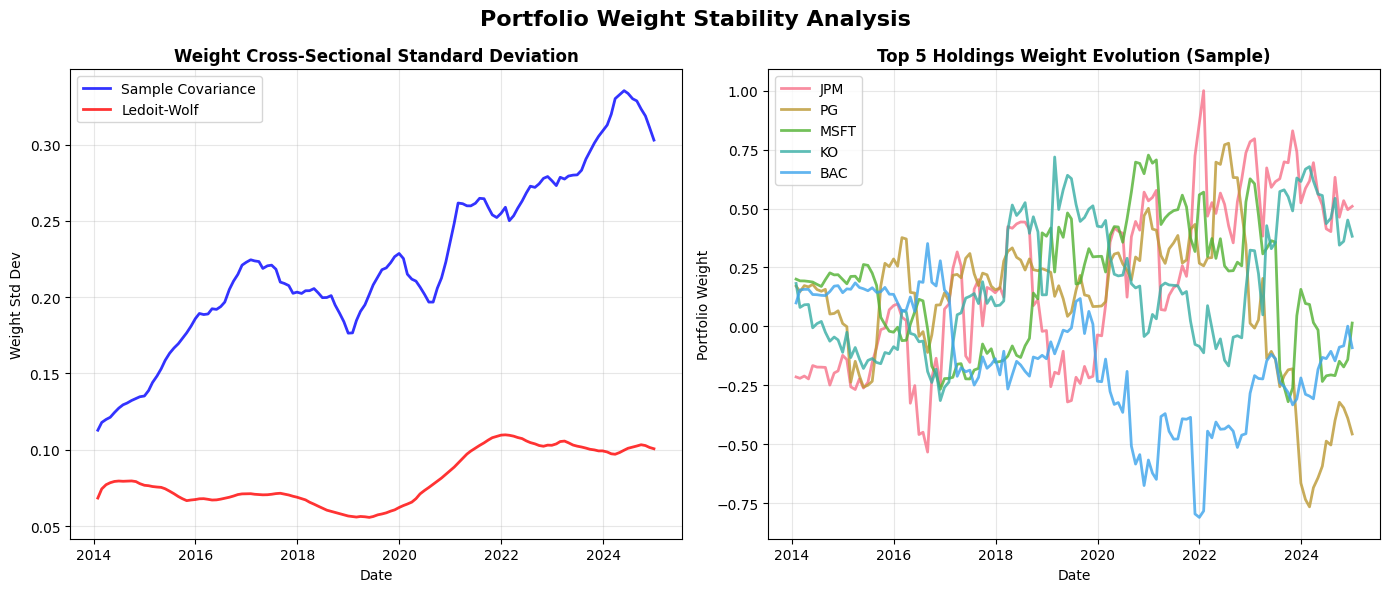

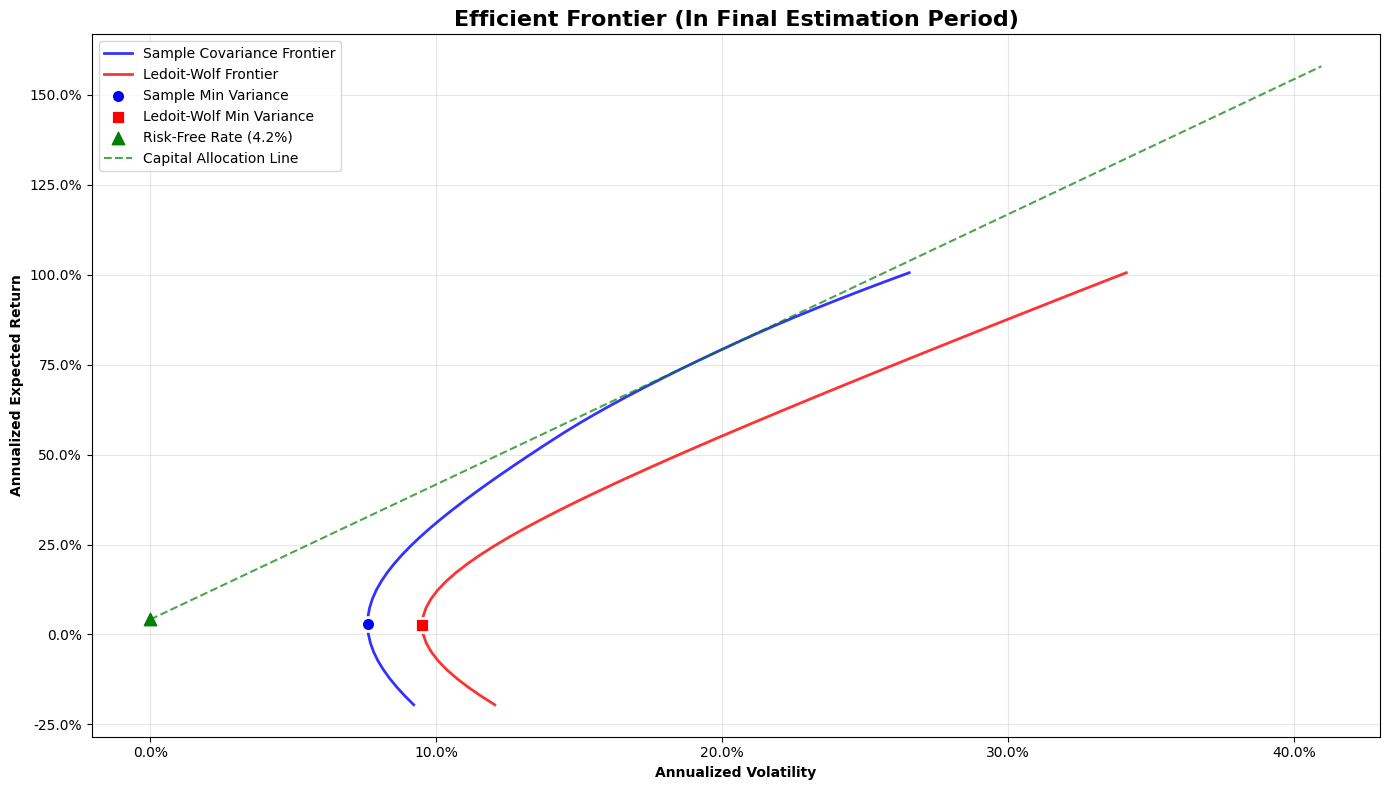

Results not saved (user selected no)

Portfolio Optimization Successful!


In [2]:
# Inputs, Validaitons, and Fallbacks

# 20 Default tickers for Portfolio
def get_default_tickers():

    return [
        'AAPL', 'MSFT', 'GOOG', 'IBM', 'NVDA',   # Technology
        'JPM', 'BAC', 'MS', 'GS',                # Financial
        'JNJ', 'PFE', 'MRK',                     # Healthcare
        'KO', 'PG', 'WMT', 'HD',                 # Consumer
        'GE', 'CAT', 'MMM',                      # Industrial
        'XOM'                                    # Energy
    ]

# Validate user inputs for tickers, start year, end year, and estimation window
def validate_inputs(tickers, start_year, end_year, estimation_window):
    total_years = end_year - start_year
    total_months = total_years * 12
    min_required_months = estimation_window + 24

    # Error warnings if the total months is too few
    if total_months < min_required_months:
        print(f"WARNING: Time period ({total_years} years) may be too short.")
        print(f"Need at least {min_required_months} months for meaningful backtest.")

    # Check minimum multi-year requirement
    if total_years < 3:
        print(f"WARNING: Assignment requires multi-year period. Consider at least 3 years.")

    # Error handling if assets numbers is outside of range
    if len(tickers) < 10:
        print("WARNING: Assignment requires at least 10 stocks for analysis.")
        # Force user to add more stocks or use defaults
        if len(tickers) < 5:
            print("ERROR: Too few stocks for meaningful portfolio optimization.")
            print("Using default tickers instead.")
            tickers = get_default_tickers()

    return tickers, start_year, end_year, estimation_window

# Queries the user for inputs with proper input validaiton and fallback to default values
def get_user_inputs():
    # Nice title
    print("\nMinimum Variance Portfolio Optimization Inputs")
    print("=" * 50)

    # STEP 1: Connect to WRDS FIRST
    print("\nConnecting to WRDS...")
    db = connect_to_wrds()
    if db is None:
        print("ERROR: Cannot proceed without WRDS connection.")
        return None

    # STEP 2: Time range / backtest period inputs
    print("\nBacktest Period:")
    # Loop until we get a valid date range
    while True:
        # Get start year
        while True:
            try:
                start_year_input = input("Start year (default 2010): ") or "2010"
                start_year = int(start_year_input)
                if start_year < 2000:
                    print("ERROR: Start year must be 2000 or later (CRSP data quality)")
                    continue
                if start_year > 2022:
                    print("ERROR: Start year must be 2022 or earlier (need time for backtest)")
                    continue
                break
            except ValueError:
                print("ERROR: Please enter a valid year (e.g., 2010)")

        # Get end year
        while True:
            try:
                end_year_input = input("End year (default 2024): ") or "2024"
                end_year = int(end_year_input)
                if end_year < 2005:
                    print("ERROR: End year must be 2005 or later")
                    continue
                if end_year > 2024:
                    print("ERROR: End year cannot be beyond 2024 (current data)")
                    continue
                if end_year <= start_year:
                    print("ERROR: End year must be greater than start year")
                    continue
                break
            except ValueError:
                print("ERROR: Please enter a valid year (e.g., 2024)")

        # Check if the period is long enough
        period_years = end_year - start_year
        if period_years < 3:
            print(f"ERROR: Period too short ({period_years} years).")
            print("Need at least 3 years for meaningful backtest.")
            print("Please enter new dates:")
            continue
        else:
            break

    # STEP 3: Stock selection WITH immediate validation
    print("\nStock Selection:")
    print("Enter tickers (space-separated) or press Enter for default 20 blue chips:")

    while True:
        user_input = input("Tickers: ").strip().upper()

        if user_input:
            raw_tickers = user_input.split()

            # Remove duplicates while preserving order
            tickers = []
            seen = set()
            duplicates = []

            for ticker in raw_tickers:
                if ticker in seen:
                    duplicates.append(ticker)
                else:
                    tickers.append(ticker)
                    seen.add(ticker)

            # Warn about duplicates if any were found
            if duplicates:
                print(f"WARNING: Removed duplicate tickers: {', '.join(duplicates)}")
                print(f"Using {len(tickers)} unique tickers: {', '.join(tickers)}")

            # Check if we have enough unique tickers
            if len(tickers) < 10:
                print(f"ERROR: Only {len(tickers)} unique tickers provided.")
                print("Assignment requires at least 10 unique stocks for meaningful analysis.")
                print("Please enter at least 10 unique tickers or press Enter for defaults:")
                continue

            print(f"Validating {len(tickers)} unique tickers from {start_year} to {end_year}...")

            # Rest of validation logic stays the same...
            temp_start = f"{start_year}-01-01"
            temp_end = f"{end_year}-12-31"
            temp_data = fetch_stock_returns(db, tickers, temp_start, temp_end)

            if temp_data is None or temp_data.empty:
                print("ERROR: No data found for these tickers in the specified period.")
                print("Please enter different tickers or press Enter for defaults:")
                continue

            # Check for insufficient data
            missing_tickers = []
            min_required_obs = period_years * 12 * 0.75  # Require 75% data coverage

            for ticker in tickers:
                if ticker not in temp_data.columns:
                    missing_tickers.append(f"{ticker} (not found)")
                elif temp_data[ticker].notna().sum() < min_required_obs:
                    coverage = temp_data[ticker].notna().sum() / len(temp_data) * 100
                    missing_tickers.append(f"{ticker} ({coverage:.0f}% coverage)")

            if missing_tickers:
                print(f"ERROR: These tickers have insufficient data:")
                for ticker in missing_tickers:
                    print(f"  - {ticker}")
                print("Please enter different tickers or press Enter for defaults:")
                continue

            print("✓ All tickers have sufficient data")
            print(f"Using {len(tickers)} unique user-specified tickers")
            break

        else:
            tickers = get_default_tickers()
            print(f"Using default 20 blue chip tickers")
            break

    # STEP 4: Estimation window input
    while True:
        try:
            estimation_window_input = input("Estimation window in months (default 36): ") or "36"
            estimation_window = int(estimation_window_input)
            if estimation_window < 6:
                print("WARNING: Estimation window should be at least 6 months")
                continue
            if estimation_window > 120:
                print("WARNING: Estimation window above 120 months may be too long")
                continue
            break
        except ValueError:
            print("ERROR: Please enter a valid number of months (e.g., 36)")

    # Validate inputs (this can stay as a final check)
    tickers, start_year, end_year, estimation_window = validate_inputs(
        tickers, start_year, end_year, estimation_window
    )

    # STEP 5: Portfolio constraints
    print("\nPortfolio Constraints:")

    # Maximum weight constraint
    while True:
        use_long_constraints = input("Apply a maximum weight for a stock? (y/n, default n): ").lower().strip()
        if use_long_constraints in ['y', 'yes', 'n', 'no', '']:
            break
        print("Please enter 'y' for yes or 'n' for no")

    if use_long_constraints in ['y', 'yes']:
        while True:
            try:
                max_long_input = input("Maximum weight per asset (e.g., 0.10 for 10%): ") or "0.10"
                max_long_weight = float(max_long_input)
                if max_long_weight <= 0:
                    print("ERROR: Maximum weight must be positive")
                    continue
                if max_long_weight > 1.0:
                    print("WARNING: Maximum weight above 100% seems unusual")
                    confirm = input("Continue with this weight? (y/n): ").lower().strip()
                    if confirm not in ['y', 'yes']:
                        continue
                break
            except ValueError:
                print("ERROR: Please enter a valid decimal (e.g., 0.10)")
    else:
        max_long_weight = 1.0

    # Short selling constraint
    while True:
        allow_short = input("Allow short positions? (y/n, default y): ").lower().strip()
        if allow_short in ['y', 'yes', 'n', 'no', '']:
            break
        print("Please enter 'y' for yes or 'n' for no")

    if allow_short == 'n' or allow_short == 'no':
        min_weight = 0.0
    else:
        while True:
            try:
                max_short_input = input("Maximum short position per asset (e.g., 0.20 for -20%, default 1.0 for -100%): ") or "1.0"
                max_short_weight = float(max_short_input)
                if max_short_weight < 0:
                    print("NOTE: Enter positive value for short limit (will be converted to negative)")
                    max_short_weight = abs(max_short_weight)
                max_short_weight = -abs(max_short_weight)
                min_weight = max_short_weight
                break
            except ValueError:
                print("ERROR: Please enter a valid decimal (e.g., 0.20)")

    max_weight = max_long_weight

    # STEP 6: Risk-free rate
    print("\nRisk-Free Rate:")
    while True:
        try:
            rf_input = input("Risk-free rate for Sharpe ratio (default 4.2%): ") or "4.2"
            risk_free_rate = float(rf_input) / 100

            if risk_free_rate < 0:
                print("WARNING: Negative risk-free rate entered. Please enter a positive value.")
                continue
            elif risk_free_rate > 0.20:
                print("WARNING: Risk-free rate above 20% seems unusually high. Please confirm.")
                confirm = input("Continue with this rate? (y/n): ").lower().strip()
                if confirm not in ['y', 'yes']:
                    continue
            elif risk_free_rate > 0.10:
                print(f"NOTE: Risk-free rate of {risk_free_rate:.1%} is quite high for typical markets.")

            break

        except ValueError:
            print("ERROR: Please enter a valid number (e.g., 2 for 2% or 0.02 for 2%)")

    # STEP 7: Data quality requirements
    print("\nData Quality Requirements:")
    while True:
        try:
            min_obs_input = input(f"Minimum observations per stock (default {estimation_window}): ") or str(estimation_window)
            min_observations = int(min_obs_input)
            if min_observations < 1:
                print("ERROR: Minimum observations must be at least 1")
                continue
            if min_observations > estimation_window:
                print(f"WARNING: Minimum observations ({min_observations}) exceeds estimation window ({estimation_window})")
                confirm = input("Continue with this setting? (y/n): ").lower().strip()
                if confirm not in ['y', 'yes']:
                    continue
            break
        except ValueError:
            print("ERROR: Please enter a valid number of observations")

    while True:
        try:
            max_missing_input = input("Maximum missing data percentage (default 10%): ") or "10"
            max_missing_pct = float(max_missing_input) / 100
            if max_missing_pct < 0 or max_missing_pct > 1:
                print("ERROR: Missing data percentage must be between 0 and 100")
                continue
            if max_missing_pct > 0.5:
                print(f"WARNING: Allowing {max_missing_pct:.0%} missing data may reduce portfolio quality")
                confirm = input("Continue with this setting? (y/n): ").lower().strip()
                if confirm not in ['y', 'yes']:
                    continue
            break
        except ValueError:
            print("ERROR: Please enter a valid percentage (e.g., 10)")

    # STEP 8: Save results option
    print("\nOutput Options:")
    while True:
        save_files = input("Save results to CSV files? (y/n): ").lower().strip()
        if save_files in ['y', 'yes', 'n', 'no']:
            break
        print("Please enter 'y' for yes or 'n' for no")

    save_results = save_files in ['y', 'yes']

    # Create constraints dictionary
    constraints = {
        'min_weight': min_weight,
        'max_weight': max_weight,
        'allow_short': not (allow_short == 'n' or allow_short == 'no'),
        'long_only': (allow_short == 'n' or allow_short == 'no')
    }

    coverage_params = {
        'min_observations': min_observations,
        'max_missing_pct': max_missing_pct
    }

    # Display summary
    print("\n" + "="*50)
    print("Configuration Summary:")
    print(f"Assets: {len(tickers)} stocks")
    print(f"Period: {start_year}-{end_year}")
    print(f"Estimation window: {estimation_window} months")
    print(f"Weight range: [{min_weight:.2f}, {max_weight:.2f}]")
    print(f"Short selling: {'Allowed' if constraints['allow_short'] else 'Prohibited'}")
    print("="*50)

    return {
        'tickers': tickers,
        'start_year': start_year,
        'end_year': end_year,
        'estimation_window': estimation_window,
        'constraints': constraints,
        'risk_free_rate': risk_free_rate,
        'coverage_params': coverage_params,
        'save_results': save_results,
        'db_connection': db  # Pass the connection
    }

# WRDS Connection and Data Fetching

# Establish connection to WRDS database with enhanced error handling
def connect_to_wrds():

    max_retries = 3
    for attempt in range(max_retries):
        try:
            print(f"Attempting WRDS connection (attempt {attempt + 1}/{max_retries})...")
            db = wrds.Connection()
            print("WRDS connection successful")
            return db
        except Exception as e:
            if attempt == max_retries - 1:
                print(f"Connection failed after {max_retries} attempts: {e}")
                print("Please check your WRDS credentials and internet connection")
                return None
            else:
                print(f"Attempt {attempt + 1} failed: {e}")
                print("Retrying...")
                time.sleep(2)  # Wait before retry
    return None

# Query WRDS CRSP datbase for monthly stock return data
"""
    Parameters:
    db: WRDS connection object
    tickers: list of stock tickers
    start_date: start date string 'YYYY-MM-DD'
    end_date: end date string 'YYYY-MM-DD'

    Returns:
    DataFrame with dates as index and tickers as columns
"""
def fetch_stock_returns(db, tickers, start_date, end_date):
    # Convert tickers to string for SQL query
    ticker_str = "', '".join(tickers)

    # SQL query for CRSP monthly stock file with proper date handling
    query = f"""
    SELECT date, ticker, ret
    FROM crsp.msf a
    LEFT JOIN crsp.msenames b
    ON a.permno = b.permno
    WHERE DATE_TRUNC('month', b.namedt) <= DATE_TRUNC('month', a.date)
    AND DATE_TRUNC('month', a.date) <= DATE_TRUNC('month', b.nameendt)
    AND a.date BETWEEN '{start_date}' AND '{end_date}'
    AND ticker IN ('{ticker_str}')
    AND ret IS NOT NULL
    ORDER BY date, ticker
    """

    try:
        # Execute query
        data = db.raw_sql(query)

        if data.empty:
            return None

        # Convert to datetime
        data['date'] = pd.to_datetime(data['date'])

        # Remove duplicates by keeping the first occurrence for each date-ticker pair
        data = data.drop_duplicates(subset=['date', 'ticker'], keep='first')

        # Pivot to get tickers as columns
        returns_df = data.pivot(index='date', columns='ticker', values='ret')

        # Sort by date
        returns_df = returns_df.sort_index()

        return returns_df

    except Exception as e:
        print(f"Error fetching data: {e}")
        return None

# Data Coverage Validation and Ticker Replacement

# Validate if tickers have sufficient data coverage within the time period, checks for missing data
def validate_ticker_coverage(returns_df, ticker_list, min_observations, max_missing_pct):

    #create lists for the both good and bad tickers
    valid_tickers = []
    insufficient_tickers = []

    #Loop through each ticker to find the coverage
    for ticker in ticker_list:
        if ticker not in returns_df.columns:
            insufficient_tickers.append(ticker)
            continue

        #Calculates the coverage stats
        series = returns_df[ticker]
        total_periods = len(returns_df)
        available_periods = series.notna().sum()
        missing_pct = ((total_periods - available_periods) / total_periods) * 100

        #checks with user's max missing percent
        passes_min_obs = available_periods >= min_observations
        passes_missing_pct = missing_pct <= (max_missing_pct * 100)

        #Groups stocks into valid or invalid
        if passes_min_obs and passes_missing_pct:
            valid_tickers.append(ticker)
        else:
            insufficient_tickers.append(ticker)

    # Show clean summary AFTER validation is done
    if not insufficient_tickers:
        print("Data validation: All tickers have sufficient data")
    else:
        print(f"Data validation: {len(insufficient_tickers)} ticker(s) have insufficient data ({', '.join(insufficient_tickers)})")
        print("How would you like to handle this?")

    return valid_tickers, insufficient_tickers

# Suggest alternative tickers for replacement values if there is missing data
def suggest_replacement_tickers():
    replacement_pool = [
        # Additional tech
        'ORCL', 'CRM', 'INTC', 'AMD', 'ADBE',
        # Additional financial
        'C', 'MS', 'AXP', 'BLK',
        # Additional consumer
        'AMZN', 'NFLX', 'DIS', 'NKE', 'SBUX',
        # Additional healthcare
        'UNH', 'ABBV', 'TMO', 'ABT',
        # Additional industrial
        'HON', 'UNP', 'LMT', 'BA',
        # Utilities
        'NEE', 'DUK', 'SO',
        # Materials
        'LIN', 'APD'
    ]
    return replacement_pool

# Interactive loop that queries the user to ask to replace insufficent tickers
def interactive_ticker_replacement(insufficient_tickers, replacement_pool, db, returns_df, config):
    if not insufficient_tickers:
        return config['tickers']

    #Shows the user which stocks have a problem
    #Gives option to remove, replace with suggested, or replace on their own
    print(f"\n{len(insufficient_tickers)} tickers failed validation: {insufficient_tickers}")
    print("Options:")
    print("1. Remove insufficient tickers and continue")
    print("2. Replace with suggested alternatives")
    print("3. Manually specify replacement tickers")

    choice = input("Choose option (1/2/3): ").strip()

    updated_tickers = [ticker for ticker in config['tickers'] if ticker not in insufficient_tickers]

    #Continues with all the valid stocks chosen (no replacement)
    if choice == '1':
        print(f"Continuing with {len(updated_tickers)} valid tickers")
        final_tickers = updated_tickers
    #Shows suggested replacements (based on indsutry) and allows replacement
    elif choice == '2':
        print("\nSuggested replacement tickers:")
        available_replacements = [t for t in replacement_pool if t not in config['tickers']]

        for i, ticker in enumerate(available_replacements[:10], 1):
            print(f"{i:2d}. {ticker}")

        selections = input("\nSelect replacements by number (e.g., 1,3,5): ").strip()

        if selections:
            try:
                indices = [int(x.strip()) - 1 for x in selections.split(',')]
                selected_tickers = [available_replacements[i] for i in indices if 0 <= i < len(available_replacements)]
                updated_tickers.extend(selected_tickers)
                print(f"Added replacements: {selected_tickers}")
            except (ValueError, IndexError):
                print("Invalid selection, continuing without replacements")

        final_tickers = updated_tickers

    #queries the user for the custom replacements they want to use
    elif choice == '3':
        manual_tickers = input("Enter replacement tickers (space-separated): ").strip().upper().split()
        if manual_tickers:
            updated_tickers.extend(manual_tickers)
            print(f"Added manual replacements: {manual_tickers}")

        final_tickers = updated_tickers
    else:
        final_tickers = updated_tickers

    # Validate new tickers if any were added
    new_tickers = [t for t in final_tickers if t not in config['tickers'] or t in insufficient_tickers]

    if new_tickers:
        print(f"\nValidating new tickers: {new_tickers}")

        # Fetch data for new tickers
        start_date = f"{config['start_year']}-01-01"
        end_date = f"{config['end_year']}-12-31"

        new_data = fetch_stock_returns(db, new_tickers, start_date, end_date)

        if new_data is not None:
            # Merge with existing data
            combined_data = returns_df.copy()
            for ticker in new_data.columns:
                combined_data[ticker] = new_data[ticker]

            # Validate new tickers
            valid_new, invalid_new = validate_ticker_coverage(
                combined_data, new_tickers,
                config['coverage_params']['min_observations'],
                config['coverage_params']['max_missing_pct']
            )

            # Keep only valid new tickers
            final_tickers = [t for t in final_tickers if t not in new_tickers or t in valid_new]
        else:
            # If new data fetch failed, remove new tickers
            final_tickers = [t for t in final_tickers if t not in new_tickers]

    # Ensure minimum ticker count
    if len(final_tickers) < 5:
        print("WARNING: Too few valid tickers. Adding default tickers.")
        default_tickers = get_default_tickers()
        final_tickers.extend([t for t in default_tickers if t not in final_tickers])

    return final_tickers

# Covariance Estimation and Portfolio Optimization

# Calcualte sample covariance matrix from estimation period stock return data
"""
    Parameters:
    returns_df: DataFrame with returns data
    estimation_start: start date for estimation window
    estimation_end: end date for estimation window

    Returns:
    sample_cov: numpy array of sample covariance matrix
    mean_returns: pandas Series of mean returns for the period
    valid_tickers: list of tickers with sufficient data
  """
def calculate_sample_covariance(returns_df, estimation_start, estimation_end):

    # Extract estimation period data
    estimation_data = returns_df.loc[estimation_start:estimation_end].copy()

    # Remove tickers with insufficient data in this window
    min_obs_threshold = int(len(estimation_data) * 0.75)  # Need at least 75% of periods
    valid_tickers = []

    for ticker in estimation_data.columns:
        if estimation_data[ticker].notna().sum() >= min_obs_threshold:
            valid_tickers.append(ticker)

    if len(valid_tickers) == 0:
        raise ValueError("No tickers have sufficient data in estimation window")

    # Keep only valid tickers and forward-fill missing values
    clean_data = estimation_data[valid_tickers].ffill().dropna()

    if clean_data.empty:
        raise ValueError("No valid data after cleaning")

    # Calculate sample covariance matrix
    sample_cov = clean_data.cov().values
    mean_returns = clean_data.mean()

    return sample_cov, mean_returns, valid_tickers

# Calculate Ledoit-Wolf shrinkage covariance estimator usking sklearn
"""
    Parameters:
    returns_df: DataFrame with returns data
    estimation_start: start date for estimation window
    estimation_end: end date for estimation window

    Returns:
    lw_cov: numpy array of Ledoit-Wolf covariance matrix
    shrinkage: shrinkage parameter used
    mean_returns: pandas Series of mean returns
    valid_tickers: list of tickers with sufficient data
"""
def calculate_ledoit_wolf_covariance(returns_df, estimation_start, estimation_end):
    # Extract estimation period data
    estimation_data = returns_df.loc[estimation_start:estimation_end].copy()

    # Remove tickers with insufficient data
    min_obs_threshold = int(len(estimation_data) * 0.75)
    valid_tickers = []

    for ticker in estimation_data.columns:
        if estimation_data[ticker].notna().sum() >= min_obs_threshold:
            valid_tickers.append(ticker)

    if len(valid_tickers) == 0:
        raise ValueError("No tickers have sufficient data in estimation window")

    # Clean data
    clean_data = estimation_data[valid_tickers].ffill().dropna()

    if clean_data.empty:
        raise ValueError("No valid data after cleaning")

    # Apply Ledoit-Wolf estimator
    lw = LedoitWolf()
    lw_cov = lw.fit(clean_data.values).covariance_
    shrinkage = lw.shrinkage_
    mean_returns = clean_data.mean()

    return lw_cov, shrinkage, mean_returns, valid_tickers

# Solve for the mininmum variance portfolio using the cvxpy package
"""
    Parameters:
    cov_matrix: numpy array of covariance matrix
    constraints: dictionary with weight constraints

    Returns:
    weights: numpy array of optimal portfolio weights
    portfolio_variance: float of minimum portfolio variance
    optimization_status: string indicating solver status
  """
def solve_minimum_variance_portfolio(cov_matrix, constraints=None):

    n_assets = cov_matrix.shape[0]

    # Define optimization variable
    w = cp.Variable(n_assets)

    # Objective function: minimize portfolio variance
    # Portfolio variance = w^T * Sigma * w
    objective = cp.Minimize(cp.quad_form(w, cov_matrix))

    # Base constraint: weights sum to 1 (fully invested)t
    base_constraints = [cp.sum(w) == 1]

    # Add position limits if specified
    if constraints is not None:
        if 'min_weight' in constraints and constraints['min_weight'] is not None:
            base_constraints.append(w >= constraints['min_weight'])

        if 'max_weight' in constraints and constraints['max_weight'] is not None:
            base_constraints.append(w <= constraints['max_weight'])

    # Create and solve optimization problem
    problem = cp.Problem(objective, base_constraints)

    # Try solvers in order of preference
    solvers_to_try = [cp.OSQP, cp.ECOS, cp.SCS]

    for solver in solvers_to_try:
        try:
            problem.solve(solver=solver, verbose=False)
            if problem.status == cp.OPTIMAL:
                weights = w.value
                portfolio_variance = objective.value
                return weights, portfolio_variance, "optimal"
            elif problem.status in [cp.INFEASIBLE, cp.UNBOUNDED]:
                print(f"WARNING: Optimization problem is {problem.status}")
                return None, None, problem.status
        except Exception:
            continue

    return None, None, "all_solvers_failed"

# Create a summary of portfolio optimization results
"""
    Parameters:
    weights: numpy array of portfolio weights
    tickers: list of ticker names
    portfolio_variance: float of portfolio variance
    shrinkage: optional shrinkage parameter for Ledoit-Wolf

    Returns:
    summary_df: DataFrame with portfolio positions
    metrics: dictionary with portfolio metrics
"""
def create_portfolio_summary(weights, tickers, portfolio_variance, shrinkage=None):
    # Create portfolio positions DataFrame
    portfolio_positions = pd.DataFrame({
        'ticker': tickers,
        'weight': weights,
        'abs_weight': np.abs(weights)
    })

    # Sort by absolute weight (largest positions first)
    portfolio_positions = portfolio_positions.sort_values('abs_weight', ascending=False)

    # Calculate portfolio metrics
    portfolio_volatility = np.sqrt(portfolio_variance) * np.sqrt(12)  # Annualized Variance
    long_weight = portfolio_positions[portfolio_positions['weight'] > 0]['weight'].sum() #weights of long positions
    short_weight = abs(portfolio_positions[portfolio_positions['weight'] < 0]['weight'].sum()) #weights of short positions
    net_exposure = long_weight - short_weight
    gross_exposure = long_weight + short_weight

    #create a dictionary for all the metrics
    metrics = {
        'portfolio_variance': portfolio_variance,
        'portfolio_volatility_annual': portfolio_volatility,
        'long_exposure': long_weight,
        'short_exposure': short_weight,
        'net_exposure': net_exposure,
        'gross_exposure': gross_exposure,
        'num_positions': len([w for w in weights if abs(w) > 0.001]),  # Positions > 0.1%
        'max_position': portfolio_positions['abs_weight'].max(),
        'min_position': portfolio_positions[portfolio_positions['abs_weight'] > 0.001]['abs_weight'].min()
    }

    if shrinkage is not None:
        metrics['shrinkage_parameter'] = shrinkage

    return portfolio_positions, metrics

# Compare sample covariance vs Ledoit-Wolf shrinkage
"""
Returns:
comparison_results: dictionary with results from both methods
"""
def compare_covariance_methods(returns_df, estimation_start, estimation_end, constraints):

    results = {}

    # Sample covariance method
    try:
        sample_cov, mean_ret_sample, tickers_sample = calculate_sample_covariance(
            returns_df, estimation_start, estimation_end
        )

        weights_sample, var_sample, status_sample = solve_minimum_variance_portfolio(
            sample_cov, constraints
        )

        if weights_sample is not None:
            portfolio_sample, metrics_sample = create_portfolio_summary(
                weights_sample, tickers_sample, var_sample
            )

            results['sample'] = {
                'weights': weights_sample,
                'portfolio_variance': var_sample,
                'portfolio_positions': portfolio_sample,
                'metrics': metrics_sample,
                'tickers': tickers_sample,
                'status': status_sample
            }
    except Exception as e:
        results['sample'] = {'error': str(e)}

    # Ledoit-Wolf method
    try:
        lw_cov, shrinkage, mean_ret_lw, tickers_lw = calculate_ledoit_wolf_covariance(
            returns_df, estimation_start, estimation_end
        )

        weights_lw, var_lw, status_lw = solve_minimum_variance_portfolio(
            lw_cov, constraints
        )

        if weights_lw is not None:
            portfolio_lw, metrics_lw = create_portfolio_summary(
                weights_lw, tickers_lw, var_lw, shrinkage
            )

            results['ledoit_wolf'] = {
                'weights': weights_lw,
                'portfolio_variance': var_lw,
                'portfolio_positions': portfolio_lw,
                'metrics': metrics_lw,
                'tickers': tickers_lw,
                'shrinkage': shrinkage,
                'status': status_lw
            }
    except Exception as e:
        results['ledoit_wolf'] = {'error': str(e)}

    return results

# Rolling Window Out-of-Sample Backtesting

def generate_backtest_dates(returns_df, estimation_window, start_year=None):
    """
    Generate monthly rebalancing dates for rolling window backtest

    Parameters:
    returns_df: DataFrame with return data
    estimation_window: number of months for lookback window
    start_year: optional year to start backtest (uses estimation_window + buffer if None)

    Returns:
    backtest_dates: list of tuples (estimation_start, estimation_end, oos_date)
    """

    # Get available date range
    all_dates = returns_df.index.sort_values()

    # Determine first out-of-sample date
    if start_year is not None:
        first_oos_date = pd.to_datetime(f"{start_year}-01-01")
        # Find closest available date
        first_oos_date = all_dates[all_dates >= first_oos_date][0]
    else:
        # Use estimation window + buffer
        buffer_months = 12  # Extra buffer for initial period
        first_oos_idx = estimation_window + buffer_months
        if first_oos_idx >= len(all_dates):
            raise ValueError("Insufficient data for backtest period")
        first_oos_date = all_dates[first_oos_idx]

    # Generate monthly rebalancing dates
    backtest_dates = []
    current_oos_date = first_oos_date

    while current_oos_date <= all_dates[-1]:
        # Find estimation window end (one month before OOS)
        try:
            estimation_end_idx = all_dates.get_loc(current_oos_date) - 1
            estimation_end = all_dates[estimation_end_idx]

            # Find estimation window start
            estimation_start_idx = max(0, estimation_end_idx - estimation_window + 1)
            estimation_start = all_dates[estimation_start_idx]

            # Verify we have sufficient data
            actual_window = estimation_end_idx - estimation_start_idx + 1
            if actual_window >= estimation_window * 0.9:  # Allow 10% tolerance
                backtest_dates.append((estimation_start, estimation_end, current_oos_date))

            # Move to next month
            next_month = current_oos_date + relativedelta(months=1)
            # Find next available date
            future_dates = all_dates[all_dates > current_oos_date]
            if len(future_dates) == 0:
                break
            current_oos_date = future_dates[0]

        except (KeyError, IndexError):
            # No more valid dates
            break

    return backtest_dates

#Execute rolling window backtest with monthly rebalancing
"""
Parameters:
returns_df: DataFrame with return data
backtest_dates: list of (est_start, est_end, oos_date) tuples
constraints: dictionary with portfolio constraints
final_tickers: list of valid tickers to use

Returns:
backtest_results: DataFrame with monthly results
portfolio_weights: DataFrame with weights over time
"""
def run_rolling_backtest(returns_df, backtest_dates, constraints, final_tickers, coverage_params):
    """
    Execute rolling window backtest with monthly rebalancing

    Parameters:
    returns_df: DataFrame with return data
    backtest_dates: list of (est_start, est_end, oos_date) tuples
    constraints: dictionary with portfolio constraints
    final_tickers: list of valid tickers to use

    Returns:
    backtest_results: DataFrame with monthly results
    portfolio_weights: DataFrame with weights over time
    """

    # Initialize results storage
    results_list = []
    weights_list = []  # Store as list of dictionaries instead

    # Use progress bar instead of numbers
    for i, (est_start, est_end, oos_date) in enumerate(tqdm(backtest_dates, desc="Processing periods")):

        try:
            # Filter returns data to final tickers
            filtered_returns = returns_df[final_tickers].copy()

            # Get estimation period data
            est_data = filtered_returns.loc[est_start:est_end]

            # Skip if insufficient data
            if len(est_data) < coverage_params.get('min_observations', 24):
                continue

            # Get out-of-sample return
            if oos_date not in filtered_returns.index:
                continue
            oos_returns = filtered_returns.loc[oos_date]

            # Skip if too many missing OOS returns
            if oos_returns.isna().sum() > len(final_tickers) * 0.2:  # >20% missing
                continue

            # Compare both covariance methods
            comparison_results = compare_covariance_methods(
                filtered_returns, est_start, est_end, constraints
            )

            # Initialize results for this period
            period_results = {
                'date': oos_date,
                'estimation_start': est_start,
                'estimation_end': est_end,
                'estimation_periods': len(est_data)
            }

            # Initialize weight record for this period
            weight_record = {'date': oos_date}

            # Process sample covariance results
            if 'sample' in comparison_results and 'error' not in comparison_results['sample']:
                sample_results = comparison_results['sample']
                sample_weights = sample_results['weights']

                # Calculate out-of-sample return
                # Align out-of-sample returns to the tickers that actually have weights this period
                oos_vec_sample = oos_returns.reindex(sample_results['tickers']).fillna(0).values
                sample_return = float(np.dot(sample_weights, oos_vec_sample))

                period_results.update({
                    'sample_return': sample_return,
                    'sample_volatility': sample_results['metrics']['portfolio_volatility_annual'],
                    'sample_num_positions': sample_results['metrics']['num_positions'],
                    'sample_max_position': sample_results['metrics']['max_position'],
                    'sample_long_exposure': sample_results['metrics']['long_exposure'],
                    'sample_short_exposure': sample_results['metrics']['short_exposure'],
                    'sample_gross_exposure': sample_results['metrics']['gross_exposure']
                })

                # Store weights for all tickers
                for ticker, weight in zip(sample_results['tickers'], sample_weights):
                    weight_record[f'{ticker}_sample'] = weight
                # Fill NaN for others
                for ticker in final_tickers:
                    if f'{ticker}_sample' not in weight_record:
                        weight_record[f'{ticker}_sample'] = np.nan

            else:
                # Fill with NaN if optimization failed
                period_results.update({
                    'sample_return': np.nan,
                    'sample_volatility': np.nan,
                    'sample_num_positions': np.nan,
                    'sample_max_position': np.nan,
                    'sample_long_exposure': np.nan,
                    'sample_short_exposure': np.nan,
                    'sample_gross_exposure': np.nan
                })

                # Fill weights with NaN
                for ticker in final_tickers:
                    weight_record[f'{ticker}_sample'] = np.nan

            # Process Ledoit-Wolf results
            if 'ledoit_wolf' in comparison_results and 'error' not in comparison_results['ledoit_wolf']:
                lw_results = comparison_results['ledoit_wolf']
                lw_weights = lw_results['weights']

                # Calculate out-of-sample return
                # Align OOS returns to the tickers that actually have weights this period
                oos_vec_lw = oos_returns.reindex(lw_results['tickers']).fillna(0).values
                lw_return = float(np.dot(lw_weights, oos_vec_lw))

                period_results.update({
                    'lw_return': lw_return,
                    'lw_volatility': lw_results['metrics']['portfolio_volatility_annual'],
                    'lw_num_positions': lw_results['metrics']['num_positions'],
                    'lw_max_position': lw_results['metrics']['max_position'],
                    'lw_long_exposure': lw_results['metrics']['long_exposure'],
                    'lw_short_exposure': lw_results['metrics']['short_exposure'],
                    'lw_gross_exposure': lw_results['metrics']['gross_exposure'],
                    'lw_shrinkage': lw_results['shrinkage']
                })

                # Store weights for all tickers
                for ticker, weight in zip(lw_results['tickers'], lw_weights):
                    weight_record[f'{ticker}_lw'] = weight
                # Fill NaN for others
                for ticker in final_tickers:
                    if f'{ticker}_lw' not in weight_record:
                        weight_record[f'{ticker}_lw'] = np.nan
            else:
                # Fill with NaN if optimization failed
                period_results.update({
                    'lw_return': np.nan,
                    'lw_volatility': np.nan,
                    'lw_num_positions': np.nan,
                    'lw_max_position': np.nan,
                    'lw_long_exposure': np.nan,
                    'lw_short_exposure': np.nan,
                    'lw_gross_exposure': np.nan,
                    'lw_shrinkage': np.nan
                })

                # Fill weights with NaN
                for ticker in final_tickers:
                    weight_record[f'{ticker}_lw'] = np.nan

            results_list.append(period_results)
            weights_list.append(weight_record)

        except Exception as e:
            continue

    # Convert results to DataFrame with error check
    if not results_list:
        print("WARNING: No valid backtest periods found")
        print("No Output")
        print("Portfolio Optimization has failed")
        print("Please try again")
        return pd.DataFrame(), pd.DataFrame()

    backtest_results = pd.DataFrame(results_list)
    backtest_results.set_index('date', inplace=True)
    backtest_results.sort_index(inplace=True)

    # Convert weights to DataFrame
    portfolio_weights = pd.DataFrame(weights_list)
    if len(portfolio_weights) > 0:
        portfolio_weights.set_index('date', inplace=True)
        portfolio_weights.sort_index(inplace=True)

    return backtest_results, portfolio_weights

def calculate_portfolio_turnover(weights_df, method='sample'):
    """
    Calculate monthly portfolio turnover based on weight changes

    Parameters:
    weights_df: DataFrame with portfolio weights over time
    method: 'sample' or 'lw' to specify which method's weights to use

    Returns:
    turnover_series: pandas Series with monthly turnover values
    """

    # Select weight columns for the specified method
    if method == 'sample':
        weight_cols = [col for col in weights_df.columns if col.endswith('_sample')]
    else:
        weight_cols = [col for col in weights_df.columns if col.endswith('_lw')]

    if len(weight_cols) == 0:
        return pd.Series(dtype=float)

    # Extract weight matrix
    weight_matrix = weights_df[weight_cols].fillna(0)

    # Calculate turnover as sum of absolute weight changes
    turnover_list = []
    dates = weight_matrix.index

    for i in range(1, len(weight_matrix)):
        current_weights = weight_matrix.iloc[i].values
        previous_weights = weight_matrix.iloc[i-1].values

        # Turnover = sum of absolute weight changes
        turnover = np.sum(np.abs(current_weights - previous_weights))
        turnover_list.append(turnover)

    # Create turnover series
    turnover_series = pd.Series(turnover_list, index=dates[1:])

    return turnover_series

def calculate_weight_stability(weights_df, method='sample', window=12):
    """
    Calculate portfolio weight stability using rolling cross-sectional standard deviation

    Parameters:
    weights_df: DataFrame with portfolio weights over time
    method: 'sample' or 'lw' to specify which method's weights to use
    window: rolling window for stability calculation

    Returns:
    stability_series: pandas Series with weight stability metrics
    """

    # Select weight columns for the specified method
    if method == 'sample':
        weight_cols = [col for col in weights_df.columns if col.endswith('_sample')]
    else:
        weight_cols = [col for col in weights_df.columns if col.endswith('_lw')]

    if len(weight_cols) == 0:
        return pd.Series(dtype=float)

    # Extract weight matrix
    weight_matrix = weights_df[weight_cols].fillna(0)

    # Calculate cross-sectional standard deviation of weights at each date
    cross_sectional_std = weight_matrix.std(axis=1)

    # Calculate rolling average of cross-sectional standard deviation
    stability_series = cross_sectional_std.rolling(window=window, min_periods=1).mean()

    return stability_series

# Performance Metrics and Diagnostics

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

# Calculate comprehensive performance metrics for backtest results
"""
Parameters:
backtest_results: DataFrame with backtest results from run_rolling_backtest
risk_free_rate: annual risk-free rate for Sharpe ratio calculation

Returns:
metrics_dict: dictionary with performance metrics for both methods
"""
def calculate_performance_metrics(backtest_results, risk_free_rate):

    metrics = {}

    # Calculate metrics for both sample and Ledoit-Wolf methods
    for method in ['sample', 'lw']:
        return_col = f'{method}_return'

        if return_col not in backtest_results.columns:
            continue

        returns = backtest_results[return_col].dropna()

        if len(returns) == 0:
            continue

        # Basic return statistics (periods, returns, volatility)
        total_periods = len(returns)
        total_return = (1 + returns).prod() - 1
        annualized_return = (1 + total_return) ** (12 / total_periods) - 1
        monthly_volatility = returns.std()
        annualized_volatility = monthly_volatility * np.sqrt(12)

        # Risk-adjusted metrics
        monthly_rf = (1 + risk_free_rate) ** (1/12) - 1
        excess_returns = returns - monthly_rf
        sharpe_ratio = excess_returns.mean() / excess_returns.std() * np.sqrt(12) if excess_returns.std() > 0 else 0

        # Downside metrics
        negative_returns = returns[returns < 0]
        downside_deviation = negative_returns.std() * np.sqrt(12) if len(negative_returns) > 0 else 0
        sortino_ratio = (annualized_return - risk_free_rate) / downside_deviation if downside_deviation > 0 else 0

        # Drawdown analysis
        cumulative_returns = (1 + returns).cumprod()
        running_max = cumulative_returns.expanding().max()
        drawdown = (cumulative_returns - running_max) / running_max
        max_drawdown = drawdown.min()

        # Positive/Negative month statistics
        positive_months = (returns > 0).sum()
        negative_months = (returns < 0).sum()
        win_rate = positive_months / total_periods if total_periods > 0 else 0

        # Average positive/negative
        avg_win = returns[returns > 0].mean() if positive_months > 0 else 0
        avg_loss = returns[returns < 0].mean() if negative_months > 0 else 0
        win_loss_ratio = abs(avg_win / avg_loss) if avg_loss != 0 else 0

        # Additional statistical tests
        skewness = stats.skew(returns)
        kurtosis = stats.kurtosis(returns)
        jarque_bera_stat, jarque_bera_p = stats.jarque_bera(returns)

        # Store metrics from above
        metrics[method] = {
            'total_periods': total_periods,
            'total_return': total_return,
            'annualized_return': annualized_return,
            'annualized_volatility': annualized_volatility,
            'sharpe_ratio': sharpe_ratio,
            'sortino_ratio': sortino_ratio,
            'max_drawdown': max_drawdown,
            'win_rate': win_rate,
            'avg_monthly_return': returns.mean(),
            'avg_win': avg_win,
            'avg_loss': avg_loss,
            'win_loss_ratio': win_loss_ratio,
            'skewness': skewness,
            'kurtosis': kurtosis,
            'jarque_bera_p': jarque_bera_p,
            'best_month': returns.max(),
            'worst_month': returns.min(),
            'positive_months': positive_months,
            'negative_months': negative_months
        }

    return metrics

# Calcualte portfolio turnover metrics for both methods
"""
Returns:
turnover_metrics: dictionary with turnover statistics
"""
def calculate_turnover_metrics(backtest_results, weights_df):

    turnover_metrics = {}

    for method in ['sample', 'lw']:

        # Calculate turnover series
        turnover_series = calculate_portfolio_turnover(weights_df, method)

        if len(turnover_series) == 0:
            continue

        # Turnover statistics
        turnover_metrics[method] = {
            'mean_turnover': turnover_series.mean(),
            'median_turnover': turnover_series.median(),
            'std_turnover': turnover_series.std(),
            'min_turnover': turnover_series.min(),
            'max_turnover': turnover_series.max(),
            'turnover_25th': turnover_series.quantile(0.25),
            'turnover_75th': turnover_series.quantile(0.75)
        }

    return turnover_metrics

# Calculate weight stability metrics
"""
Parameters:
weights_df: DataFrame with portfolio weights over time
"""
def calculate_stability_metrics(weights_df):

    stability_metrics = {}

    for method in ['sample', 'lw']:

        # Calculate stability series
        stability_series = calculate_weight_stability(weights_df, method)

        if len(stability_series) == 0:
            continue

        # Stability statistics
        stability_metrics[method] = {
            'mean_stability': stability_series.mean(),
            'median_stability': stability_series.median(),
            'std_stability': stability_series.std(),
            'min_stability': stability_series.min(),
            'max_stability': stability_series.max(),
            'stability_trend': np.polyfit(range(len(stability_series)), stability_series.values, 1)[0]
        }

    return stability_metrics

# Create formatted summary table of performance metrics
"""
Returns:
summary_df: DataFrame with formatted performance comparison
"""
def create_performance_summary_table(performance_metrics):

    if not performance_metrics:
        return pd.DataFrame()

    # Define metrics to display
    display_metrics = [
        ('Total Return', 'total_return', '{:.2%}'),
        ('Annualized Return', 'annualized_return', '{:.2%}'),
        ('Annualized Volatility', 'annualized_volatility', '{:.2%}'),
        ('Sharpe Ratio', 'sharpe_ratio', '{:.3f}'),
        ('Sortino Ratio', 'sortino_ratio', '{:.3f}'),
        ('Maximum Drawdown', 'max_drawdown', '{:.2%}'),
        ('Win Rate', 'win_rate', '{:.1%}'),
        ('Best Month', 'best_month', '{:.2%}'),
        ('Worst Month', 'worst_month', '{:.2%}'),
        ('Skewness', 'skewness', '{:.3f}'),
        ('Kurtosis', 'kurtosis', '{:.3f}')
    ]

    # Build summary table
    summary_data = {}

    for method in performance_metrics:
        method_name = 'Sample Covariance' if method == 'sample' else 'Ledoit-Wolf'
        summary_data[method_name] = []

        for display_name, metric_key, format_str in display_metrics:
            value = performance_metrics[method].get(metric_key, np.nan)
            if not np.isnan(value):
                formatted_value = format_str.format(value)
            else:
                formatted_value = 'N/A'
            summary_data[method_name].append(formatted_value)

    # Create DataFrame
    metric_names = [item[0] for item in display_metrics]
    summary_df = pd.DataFrame(summary_data, index=metric_names)

    return summary_df

# Create tables showing final period portfolio weights for both methods
"""
Create tables showing final period portfolio weights for both methods

Returns:
sample_weights_df: DataFrame with sample covariance weights
lw_weights_df: DataFrame with Ledoit-Wolf weights
"""
def create_portfolio_weights_table(backtest_results, portfolio_weights, final_tickers):

    if portfolio_weights.empty or len(portfolio_weights) == 0:
        return pd.DataFrame(), pd.DataFrame()

    # Get the most recent (final) portfolio weights
    final_date = portfolio_weights.index[-1]
    final_weights = portfolio_weights.loc[final_date]

    # Extract sample covariance weights
    sample_weight_data = []
    for ticker in final_tickers:
        sample_col = f'{ticker}_sample'
        if sample_col in final_weights and not pd.isna(final_weights[sample_col]):
            weight = final_weights[sample_col]
            sample_weight_data.append({
                'Ticker': ticker,
                'Weight': weight,
                'Abs Weight': abs(weight),
                'Position': 'Long' if weight > 0 else 'Short' if weight < 0 else 'Zero'
            })

    # Extract Ledoit-Wolf weights
    lw_weight_data = []
    for ticker in final_tickers:
        lw_col = f'{ticker}_lw'
        if lw_col in final_weights and not pd.isna(final_weights[lw_col]):
            weight = final_weights[lw_col]
            lw_weight_data.append({
                'Ticker': ticker,
                'Weight': weight,
                'Abs Weight': abs(weight),
                'Position': 'Long' if weight > 0 else 'Short' if weight < 0 else 'Zero'
            })

    # Create DataFrames and sort by absolute weight
    sample_weights_df = pd.DataFrame(sample_weight_data)
    lw_weights_df = pd.DataFrame(lw_weight_data)

    if not sample_weights_df.empty:
        sample_weights_df = sample_weights_df.sort_values('Abs Weight', ascending=False)
        sample_weights_df['Weight'] = sample_weights_df['Weight'].apply(lambda x: f'{x:.3f}')
        sample_weights_df['Abs Weight'] = sample_weights_df['Abs Weight'].apply(lambda x: f'{x:.3f}')
        sample_weights_df = sample_weights_df[['Ticker', 'Weight', 'Position']]  # Keep only relevant columns

    if not lw_weights_df.empty:
        lw_weights_df = lw_weights_df.sort_values('Abs Weight', ascending=False)
        lw_weights_df['Weight'] = lw_weights_df['Weight'].apply(lambda x: f'{x:.3f}')
        lw_weights_df['Abs Weight'] = lw_weights_df['Abs Weight'].apply(lambda x: f'{x:.3f}')
        lw_weights_df = lw_weights_df[['Ticker', 'Weight', 'Position']]  # Keep only relevant columns

    return sample_weights_df, lw_weights_df

# Further plots based on the stability of portfolio weights
# Plot portfolio weight stability analysis
def plot_weight_stability(weights_df, figsize=(14, 6)):

    fig, axes = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle('Portfolio Weight Stability Analysis', fontsize=16, fontweight='bold')

    # Plot 1: Weight Stability Time Series
    ax1 = axes[0]

    for method, color, label in [('sample', 'blue', 'Sample Covariance'),
                                ('lw', 'red', 'Ledoit-Wolf')]:
        stability_series = calculate_weight_stability(weights_df, method)
        if len(stability_series) > 0:
            ax1.plot(stability_series.index, stability_series.values,
                    color=color, linewidth=2, label=label, alpha=0.8)

    ax1.set_title('Weight Cross-Sectional Standard Deviation', fontweight='bold')
    ax1.set_ylabel('Weight Std Dev')
    ax1.set_xlabel('Date')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot 2: Average Weight Evolution for Top Holdings
    ax2 = axes[1]

    # Find most common top holdings
    sample_cols = [col for col in weights_df.columns if col.endswith('_sample')]
    if sample_cols:
        avg_weights = weights_df[sample_cols].abs().mean().sort_values(ascending=False)
        top_holdings = avg_weights.head(5).index

        for i, col in enumerate(top_holdings):
            ticker = col.replace('_sample', '')
            weights_ts = weights_df[col].fillna(0)
            ax2.plot(weights_ts.index, weights_ts.values,
                    linewidth=2, label=ticker, alpha=0.8)

    ax2.set_title('Top 5 Holdings Weight Evolution (Sample)', fontweight='bold')
    ax2.set_ylabel('Portfolio Weight')
    ax2.set_xlabel('Date')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    return fig

# Create comprehensive diagnostic report, shows sharpe ratio and volatility
"""
    Returns:
    report_text: formatted string with diagnostic insights
"""
def create_diagnostic_report(performance_metrics, turnover_metrics, stability_metrics):

    report_sections = []

    # Performance comparison between L-W and sample
    if 'sample' in performance_metrics and 'lw' in performance_metrics:
        #Sharpe Ratios
        sample_sharpe = performance_metrics['sample']['sharpe_ratio']
        lw_sharpe = performance_metrics['lw']['sharpe_ratio']
        #Volatilities
        sample_vol = performance_metrics['sample']['annualized_volatility']
        lw_vol = performance_metrics['lw']['annualized_volatility']

        report_sections.append("PERFORMANCE COMPARISON")
        report_sections.append("=" * 50)

        #Displays a message about which portfolio is superior based on SR and Vol
        #Sharpe Ratio compare
        if lw_sharpe > sample_sharpe:
            report_sections.append(f"• Ledoit-Wolf shows superior risk-adjusted returns (Sharpe: {lw_sharpe:.3f} vs {sample_sharpe:.3f})")
        else:
            report_sections.append(f"• Sample covariance shows superior risk-adjusted returns (Sharpe: {sample_sharpe:.3f} vs {lw_sharpe:.3f})")

        #Volatility compare
        if lw_vol < sample_vol:
            vol_diff = (sample_vol - lw_vol) / sample_vol * 100
            report_sections.append(f"• Ledoit-Wolf reduces portfolio volatility by {vol_diff:.1f}%")
        else:
            vol_diff = (lw_vol - sample_vol) / sample_vol * 100
            report_sections.append(f"• Sample covariance shows {vol_diff:.1f}% lower volatility")

    # Displays messages about each portfolio's turnover
    # Turnover analysis
    if turnover_metrics:
        report_sections.append("\nTURNOVER ANALYSIS")
        report_sections.append("=" * 50)

        for method in turnover_metrics:
            method_name = 'Sample' if method == 'sample' else 'Ledoit-Wolf'
            mean_turnover = turnover_metrics[method]['mean_turnover']
            report_sections.append(f"• {method_name} average monthly turnover: {mean_turnover:.1%}")

            #Includes additional info for user based on the turnover analysis
            if mean_turnover > 0.5:
                report_sections.append(f"  WARNING: High turnover may indicate unstable optimization")
            elif mean_turnover < 0.1:
                report_sections.append(f"  NOTE: Low turnover suggests stable portfolio weights")

    # Creates messages for user based on stability of the weights
    # Stability analysis
    if stability_metrics:
        report_sections.append("\nSTABILITY ANALYSIS")
        report_sections.append("=" * 50)

        for method in stability_metrics:
            method_name = 'Sample' if method == 'sample' else 'Ledoit-Wolf'
            trend = stability_metrics[method]['stability_trend']

            #guidance for the investor taken from analyzing the stability
            if abs(trend) < 0.001:
                report_sections.append(f"• {method_name} weight stability remains consistent over time")
            elif trend > 0.001:
                report_sections.append(f"• {method_name} portfolio weights becoming less stable over time")
            else:
                report_sections.append(f"• {method_name} portfolio weights becoming more stable over time")

    return '\n'.join(report_sections)

# Plot portfolio turnover analysis with consistent width
def plot_turnover_analysis(backtest_results, weights_df, figsize=(14, 6)):

    fig, axes = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle('Portfolio Turnover Analysis', fontsize=16, fontweight='bold')

    # Plot 1: Turnover Time Series
    ax1 = axes[0]

    for method, color, label in [('sample', 'blue', 'Sample Covariance'),
                                ('lw', 'red', 'Ledoit-Wolf')]:
        turnover_series = calculate_portfolio_turnover(weights_df, method)
        if len(turnover_series) > 0:
            ax1.plot(turnover_series.index, turnover_series.values,
                    color=color, linewidth=2, label=label, alpha=0.8)

    ax1.set_title('Monthly Portfolio Turnover', fontweight='bold')
    ax1.set_ylabel('Turnover')
    ax1.set_xlabel('Date')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot 2: Turnover Distribution
    ax2 = axes[1]

    turnover_data = []
    labels = []
    colors = []

    for method, color, label in [('sample', 'blue', 'Sample Covariance'),
                                ('lw', 'red', 'Ledoit-Wolf')]:
        turnover_series = calculate_portfolio_turnover(weights_df, method)
        if len(turnover_series) > 0:
            turnover_data.append(turnover_series.values)
            labels.append(label)
            colors.append(color)

    if turnover_data:
        ax2.boxplot(turnover_data, labels=labels, patch_artist=True,
                   boxprops=dict(facecolor='lightblue', alpha=0.7))

    ax2.set_title('Turnover Distribution', fontweight='bold')
    ax2.set_ylabel('Turnover')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    return fig

# Plot simplified performance focused on cumulative returns and rolling window effects
def plot_simplified_performance(backtest_results, figsize=(14, 8)):

    fig, axes = plt.subplots(2, 2, figsize=figsize)
    fig.suptitle('Portfolio Performance: Rolling Window Analysis', fontsize=16, fontweight='bold')

    # Plot 1: Cumulative Returns (main requirement) graphed for both Sample and L-W portfolios
    ax1 = axes[0, 0]

    for method, color, label in [('sample', 'blue', 'Sample Covariance'),
                                ('lw', 'red', 'Ledoit-Wolf')]:
        return_col = f'{method}_return'
        if return_col in backtest_results.columns:
            returns = backtest_results[return_col].dropna()
            if len(returns) > 0:
                cumulative = (1 + returns).cumprod()
                ax1.plot(cumulative.index, cumulative.values,
                        color=color, linewidth=2.5, label=label, alpha=0.9)

    ax1.set_title('Cumulative Returns (Rolling Window)', fontweight='bold')
    ax1.set_ylabel('Cumulative Return')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot 2: Rolling Sharpe Ratio (shows rolling window effect)
    ax2 = axes[0, 1]

    for method, color, label in [('sample', 'blue', 'Sample Covariance'),
                                ('lw', 'red', 'Ledoit-Wolf')]:
        return_col = f'{method}_return'
        if return_col in backtest_results.columns:
            returns = backtest_results[return_col].dropna()
            if len(returns) > 0:
                rolling_sharpe = returns.rolling(12).apply(
                    lambda x: x.mean() / x.std() * np.sqrt(12) if x.std() > 0 else 0
                )
                ax2.plot(rolling_sharpe.index, rolling_sharpe.values,
                        color=color, linewidth=2, label=label, alpha=0.8)

    ax2.set_title('12-Month Rolling Sharpe Ratio', fontweight='bold')
    ax2.set_ylabel('Sharpe Ratio')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)

    # Plot 3: Rolling Volatility (shows adaptation over time)
    ax3 = axes[1, 0]

    for method, color, label in [('sample', 'blue', 'Sample Covariance'),
                                ('lw', 'red', 'Ledoit-Wolf')]:
        return_col = f'{method}_return'
        if return_col in backtest_results.columns:
            returns = backtest_results[return_col].dropna()
            if len(returns) > 0:
                rolling_vol = returns.rolling(12).std() * np.sqrt(12)
                ax3.plot(rolling_vol.index, rolling_vol.values,
                        color=color, linewidth=2, label=label, alpha=0.8)

    ax3.set_title('12-Month Rolling Volatility', fontweight='bold')
    ax3.set_ylabel('Annualized Volatility')
    ax3.set_xlabel('Date')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # Plot 4: Ledoit-Wolf Shrinkage Over Time (shows rolling window adaptation)
    ax4 = axes[1, 1]

    if 'lw_shrinkage' in backtest_results.columns:
        shrinkage_data = backtest_results['lw_shrinkage'].dropna()
        ax4.plot(shrinkage_data.index, shrinkage_data.values,
                color='green', linewidth=2, alpha=0.8)
        ax4.fill_between(shrinkage_data.index, shrinkage_data.values, alpha=0.3, color='green')

    ax4.set_title('Ledoit-Wolf Shrinkage Parameter Evolution', fontweight='bold')
    ax4.set_ylabel('Shrinkage Intensity')
    ax4.set_xlabel('Date')
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    return fig

# Calculate weight distribution metrics, showing cross sectional standard deviation
"""
    Parameters:
    weights_df: DataFrame with portfolio weights over time

    Returns:
    distribution_metrics: dictionary with weight distribution statistics
"""
def calculate_weight_distribution_metrics(weights_df):

    distribution_metrics = {}

    for method in ['sample', 'lw']:

        # Select weight columns for the specified method
        if method == 'sample':
            weight_cols = [col for col in weights_df.columns if col.endswith('_sample')]
        else:
            weight_cols = [col for col in weights_df.columns if col.endswith('_lw')]

        if len(weight_cols) == 0:
            continue

        # Extract weight matrix
        weight_matrix = weights_df[weight_cols].fillna(0)

        # Calculate cross-sectional standard deviation of weights at each date
        cross_sectional_stds = weight_matrix.std(axis=1)

        # Calculate statistics
        distribution_metrics[method] = {
            'mean_weight_std': cross_sectional_stds.mean(),
            'median_weight_std': cross_sectional_stds.median(),
            'max_weight_std': cross_sectional_stds.max(),
            'min_weight_std': cross_sectional_stds.min()
        }

    return distribution_metrics

# End of the period Efficient Frontier with Capital Allocation Line
"""
Plot efficient frontier using the final estimation period data
Shows where sample and Ledoit-Wolf minimum variance portfolios sit on the frontier
"""
def plot_efficient_frontier(backtest_results, returns_df, config, risk_free_rate, figsize=(14, 8)):
    """
    Plot efficient frontier using the final estimation period data
    Shows where sample and Ledoit-Wolf minimum variance portfolios sit on the frontier
    """

    fig, ax = plt.subplots(figsize=figsize)

    try:
        # Use the last backtest period for frontier calculation
        final_tickers = config['final_tickers']
        estimation_window = config['estimation_window']

        # Get the last estimation period
        all_dates = returns_df.index.sort_values()
        end_date = all_dates[-1]
        start_idx = len(all_dates) - estimation_window
        start_date = all_dates[start_idx]

        # Get data for final period
        final_period_data = returns_df[final_tickers].loc[start_date:end_date].ffill().dropna()

        if len(final_period_data) < 12:  # Need minimum data
            ax.text(0.5, 0.5, 'Insufficient data for efficient frontier',
                   ha='center', va='center', transform=ax.transAxes, fontsize=14)
            ax.set_title('Efficient Frontier (Final Period)', fontweight='bold', fontsize=16)
            return fig

        # Calculate covariance matrices
        sample_cov = final_period_data.cov().values

        # Ledoit-Wolf covariance
        lw = LedoitWolf()
        lw_cov = lw.fit(final_period_data.values).covariance_

        # Calculate mean returns (annualized)
        mean_returns = final_period_data.mean().values * 12

        # Generate efficient frontier points
        n_assets = len(final_tickers)
        target_returns = np.linspace(mean_returns.min(), mean_returns.max() * 1.5, 50)

        # Store frontier results
        sample_frontier_vol = []
        lw_frontier_vol = []

        for target_ret in target_returns:
            # Sample covariance frontier point
            try:
                w = cp.Variable(n_assets)
                portfolio_return = mean_returns.T @ w
                portfolio_variance = cp.quad_form(w, sample_cov)

                constraints = [cp.sum(w) == 1, portfolio_return == target_ret]

                # Add position constraints if specified
                if config['constraints']['min_weight'] is not None:
                    constraints.append(w >= config['constraints']['min_weight'])
                if config['constraints']['max_weight'] is not None:
                    constraints.append(w <= config['constraints']['max_weight'])

                prob = cp.Problem(cp.Minimize(portfolio_variance), constraints)
                prob.solve(verbose=False)

                if prob.status == cp.OPTIMAL:
                    sample_frontier_vol.append(np.sqrt(prob.value) * np.sqrt(12))
                else:
                    sample_frontier_vol.append(np.nan)
            except:
                sample_frontier_vol.append(np.nan)

            # Ledoit-Wolf frontier point
            try:
                w = cp.Variable(n_assets)
                portfolio_return = mean_returns.T @ w
                portfolio_variance = cp.quad_form(w, lw_cov)

                constraints = [cp.sum(w) == 1, portfolio_return == target_ret]

                # Add position constraints if specified
                if config['constraints']['min_weight'] is not None:
                    constraints.append(w >= config['constraints']['min_weight'])
                if config['constraints']['max_weight'] is not None:
                    constraints.append(w <= config['constraints']['max_weight'])

                prob = cp.Problem(cp.Minimize(portfolio_variance), constraints)
                prob.solve(verbose=False)

                if prob.status == cp.OPTIMAL:
                    lw_frontier_vol.append(np.sqrt(prob.value) * np.sqrt(12))
                else:
                    lw_frontier_vol.append(np.nan)
            except:
                lw_frontier_vol.append(np.nan)

        # Convert to arrays and remove NaN values
        sample_frontier_vol = np.array(sample_frontier_vol)
        lw_frontier_vol = np.array(lw_frontier_vol)

        # Plot efficient frontiers
        sample_valid = ~np.isnan(sample_frontier_vol)
        lw_valid = ~np.isnan(lw_frontier_vol)

        if np.any(sample_valid):
            ax.plot(sample_frontier_vol[sample_valid], target_returns[sample_valid],
                   'b-', linewidth=2, alpha=0.8, label='Sample Covariance Frontier')

        if np.any(lw_valid):
            ax.plot(lw_frontier_vol[lw_valid], target_returns[lw_valid],
                   'r-', linewidth=2, alpha=0.8, label='Ledoit-Wolf Frontier')

        # Calculate and plot minimum variance portfolios
        # Sample minimum variance
        w_sample = cp.Variable(n_assets)
        objective_sample = cp.Minimize(cp.quad_form(w_sample, sample_cov))
        constraints_sample = [cp.sum(w_sample) == 1]

        if config['constraints']['min_weight'] is not None:
            constraints_sample.append(w_sample >= config['constraints']['min_weight'])
        if config['constraints']['max_weight'] is not None:
            constraints_sample.append(w_sample <= config['constraints']['max_weight'])

        prob_sample = cp.Problem(objective_sample, constraints_sample)
        prob_sample.solve(verbose=False)

        if prob_sample.status == cp.OPTIMAL:
            sample_weights = w_sample.value
            sample_ret = np.sum(sample_weights * mean_returns)
            sample_vol = np.sqrt(objective_sample.value) * np.sqrt(12)
            ax.scatter(sample_vol, sample_ret, color='blue', s=100, marker='o',
                      label='Sample Min Variance', zorder=5, edgecolors='white', linewidth=2)

        # Ledoit-Wolf minimum variance
        w_lw = cp.Variable(n_assets)
        objective_lw = cp.Minimize(cp.quad_form(w_lw, lw_cov))
        constraints_lw = [cp.sum(w_lw) == 1]

        if config['constraints']['min_weight'] is not None:
            constraints_lw.append(w_lw >= config['constraints']['min_weight'])
        if config['constraints']['max_weight'] is not None:
            constraints_lw.append(w_lw <= config['constraints']['max_weight'])

        prob_lw = cp.Problem(objective_lw, constraints_lw)
        prob_lw.solve(verbose=False)

        if prob_lw.status == cp.OPTIMAL:
            lw_weights = w_lw.value
            lw_ret = np.sum(lw_weights * mean_returns)
            lw_vol = np.sqrt(objective_lw.value) * np.sqrt(12)
            ax.scatter(lw_vol, lw_ret, color='red', s=100, marker='s',
                      label='Ledoit-Wolf Min Variance', zorder=5, edgecolors='white', linewidth=2)

        # Add risk-free rate point
        ax.scatter(0, risk_free_rate, color='green', s=80, marker='^',
                  label=f'Risk-Free Rate ({risk_free_rate:.1%})', zorder=5)

        # Add capital allocation line for best Sharpe ratio portfolio
        if np.any(sample_valid):
            # Find tangency portfolio for sample covariance
            sharpe_vals = (target_returns[sample_valid] - risk_free_rate) / sample_frontier_vol[sample_valid]
            if np.all(np.isnan(sharpe_vals)):
                pass  # skip CAL if all invalid
            else:
                best_sharpe_idx = np.nanargmax(sharpe_vals)
                tangency_ret = target_returns[sample_valid][best_sharpe_idx]
                tangency_vol = sample_frontier_vol[sample_valid][best_sharpe_idx]
                max_vol = max(np.nanmax(sample_frontier_vol), np.nanmax(lw_frontier_vol)) * 1.2
                cal_vols = np.linspace(0, max_vol, 100)
                cal_rets = risk_free_rate + (tangency_ret - risk_free_rate) / tangency_vol * cal_vols
                ax.plot(cal_vols, cal_rets, 'g--', alpha=0.7, linewidth=1.5, label='Capital Allocation Line')


    except Exception as e:
        ax.text(0.5, 0.5, f'Error generating efficient frontier: {str(e)[:50]}...',
               ha='center', va='center', transform=ax.transAxes, fontsize=12)

    ax.set_xlabel('Annualized Volatility', fontweight='bold')
    ax.set_ylabel('Annualized Expected Return', fontweight='bold')
    ax.set_title('Efficient Frontier (In Final Estimation Period)', fontweight='bold', fontsize=16)
    ax.legend(loc='upper left')
    ax.grid(True, alpha=0.3)

    # Format axes as percentages
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.1%}'.format(y)))
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.1%}'.format(x)))

    plt.tight_layout()
    return fig

# Save all backtest results to files
"""
Parameters:
results: results dictionary from main execution
output_dir: directory to save results
"""
def save_backtest_results(results, output_dir='portfolio_results'):

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)


    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    # Save backtest results in CSV
    print('\n')
    if results['backtest_results'] is not None:
        filename = f"{output_dir}/backtest_results_{timestamp}.csv"
        results['backtest_results'].to_csv(filename)
        print(f"Saved backtest results: {filename}")

    # Save portfolio weights in CSV
    if results['portfolio_weights'] is not None:
        filename = f"{output_dir}/portfolio_weights_{timestamp}.csv"
        results['portfolio_weights'].to_csv(filename)
        print(f"Saved portfolio weights: {filename}")

    # Save performance summary with weights in csv
    if results['summary_table'] is not None:
        perf_filename = f"{output_dir}/performance_summary_{timestamp}.csv"

        # Create a comprehensive summary file
        with open(perf_filename, 'w') as f:
            f.write("PERFORMANCE SUMMARY\n")
            f.write("="*50 + "\n\n")
            results['summary_table'].to_csv(f)

            # Add final portfolio weights if available
            if ('sample_weights_table' in results and 'lw_weights_table' in results and
                results['sample_weights_table'] is not None and
                not results['sample_weights_table'].empty):

                f.write("\n\nFINAL PERIOD PORTFOLIO WEIGHTS\n")
                f.write("="*50 + "\n\n")
                f.write("Sample Covariance Method:\n")
                results['sample_weights_table'].to_csv(f, index=False)

                f.write("\nLedoit-Wolf Method:\n")
                results['lw_weights_table'].to_csv(f, index=False)

        print(f"Saved performance summary with weights: {perf_filename}")

    # Save diagnostic report
    if results['diagnostic_report'] is not None:
        diag_filename = f"{output_dir}/diagnostic_report_{timestamp}.txt"
        with open(diag_filename, 'w') as f:
            f.write("MINIMUM VARIANCE PORTFOLIO OPTIMIZATION - DIAGNOSTIC REPORT\n")
            f.write("=" * 80 + "\n\n")
            f.write(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")

            # Configuration summary
            if results['config']:
                f.write("CONFIGURATION:\n")
                f.write("-" * 40 + "\n")
                config = results['config']
                f.write(f"Assets: {len(config.get('final_tickers', config['tickers']))} stocks\n")
                f.write(f"Period: {config['start_year']}-{config['end_year']}\n")
                f.write(f"Estimation window: {config['estimation_window']} months\n")
                f.write(f"Weight constraints: [{config['constraints']['min_weight']:.2f}, {config['constraints']['max_weight']:.2f}]\n")
                f.write(f"Short selling: {'Allowed' if config['constraints']['allow_short'] else 'Prohibited'}\n\n")

            f.write(results['diagnostic_report'])

        print(f"Saved diagnostic report: {diag_filename}")

    # Save plots
    for plot_name, fig in results['plots'].items():
        if fig is not None:
            filename = f"{output_dir}/{plot_name}_plot_{timestamp}.png"
            fig.savefig(filename, dpi=300, bbox_inches='tight')
            print(f"Saved {plot_name} plot: {filename}")

# Main Execution Function - Complete Portfolio Optimization

# The main function to executre the complete portfolio optimization with rolling window backtesting
"""
Parameters:
config: optional configuration dictionary (if None, will prompt user)
save_results: whether to save CSV and plot outputs
output_dir: directory to save results

Returns:
results_dict: dictionary containing all results and analysis
"""
def run_portfolio_optimization_backtest(config=None, save_results=None, output_dir='portfolio_results'):

    # Nice title for main
    print("Minimum Variance Portfolio Optimization with Rolling Window Backtest")
    print("=" * 50)

    results = {
        'success': False,
        'config': None,
        'backtest_results': None,
        'portfolio_weights': None,
        'performance_metrics': None,
        'turnover_metrics': None,
        'stability_metrics': None,
        'summary_table': None,
        'diagnostic_report': None,
        'plots': {},
        'errors': []
    }

    try:
        # Get Configuration (includes WRDS connection)
        if config is None:
            config = get_user_inputs()

        if config is None:
            results['errors'].append("Configuration setup cancelled by user")
            return results

        # Use the existing connection from config
        db = config.get('db_connection')
        if db is None:
            results['errors'].append("Failed to establish WRDS connection")
            return results

        results['config'] = config

        # Fetch Data
        print(f"Fetching data for {len(config['tickers'])} assets ({config['start_year']}-{config['end_year']})...")
        start_date = f"{config['start_year']}-01-01"
        end_date = f"{config['end_year']}-12-31"

        # Pull monthly returns for chosen stocks
        returns_data = fetch_stock_returns(db, config['tickers'], start_date, end_date)

        if returns_data is None:
            results['errors'].append("Failed to fetch return data")
            db.close()
            return results

        # Data Validation (background)
        # Find backtest window from data
        temp_backtest_dates = generate_backtest_dates(
            returns_data,
            config['estimation_window'],
            config.get('backtest_start_year', None)
        )

        if not temp_backtest_dates:
            results['errors'].append("Could not generate backtest dates")
            db.close()
            return results

        # Time period for analysis
        analysis_start = temp_backtest_dates[0][0]
        analysis_end = temp_backtest_dates[-1][2]
        analysis_period_data = returns_data.loc[analysis_start:analysis_end]

        # Identify and make sure the tickers have sufficient observations
        valid_tickers, insufficient_tickers = validate_ticker_coverage(
            analysis_period_data,
            config['tickers'],
            config['coverage_params']['min_observations'],
            config['coverage_params']['max_missing_pct']
        )

        # Confirm the final stocks chosen based on having enough coverage
        if insufficient_tickers:
            replacement_pool = suggest_replacement_tickers()
            final_tickers = interactive_ticker_replacement(
                insufficient_tickers, replacement_pool, db, returns_data, config
            )
        else:
            final_tickers = valid_tickers

        config['final_tickers'] = final_tickers

        # Generate Backtest Schedule
        backtest_dates = generate_backtest_dates(
            returns_data,
            config['estimation_window'],
            config.get('backtest_start_year', None)
        )

        print(f"Running backtest: {len(backtest_dates)} periods ({backtest_dates[0][2].strftime('%Y-%m')} to {backtest_dates[-1][2].strftime('%Y-%m')})")

        # Execute Rolling Backtest with progress
        backtest_results, portfolio_weights = run_rolling_backtest(returns_data, backtest_dates, config['constraints'], final_tickers, config['coverage_params'])

        if backtest_results.empty:
            results['errors'].append("Backtest produced no results")
            db.close()
            return results

        results['backtest_results'] = backtest_results
        results['portfolio_weights'] = portfolio_weights

        # Close the database connection
        db.close()

        # Calculate Performance Metrics and Analyze Performance
        print("Analyzing results...")

        # Compute key metrics
        performance_metrics = calculate_performance_metrics(backtest_results, config['risk_free_rate'])
        results['performance_metrics'] = performance_metrics

        # Compute turnover
        turnover_metrics = calculate_turnover_metrics(backtest_results, portfolio_weights)
        results['turnover_metrics'] = turnover_metrics

        # Compute stability
        stability_metrics = calculate_stability_metrics(portfolio_weights)
        results['stability_metrics'] = stability_metrics

        # Calculate weight distribution metrics
        weight_distribution_metrics = calculate_weight_distribution_metrics(portfolio_weights)
        results['weight_distribution_metrics'] = weight_distribution_metrics

        # Create a summary table of the above metrics to easily view
        summary_table = create_performance_summary_table(performance_metrics)
        results['summary_table'] = summary_table

        diagnostic_report = create_diagnostic_report(
            performance_metrics, turnover_metrics, stability_metrics
        )
        results['diagnostic_report'] = diagnostic_report

        # Display Results with Tables and Charts
        print("\n" + "="*60)
        print("PERFORMANCE RESULTS")
        print("="*60)
        print(summary_table)

        # Portfolio Weights Tables
        sample_weights_table, lw_weights_table = create_portfolio_weights_table(
            backtest_results, portfolio_weights, final_tickers
        )

        # Store weight tables in results for saving
        results['sample_weights_table'] = sample_weights_table
        results['lw_weights_table'] = lw_weights_table

        if not sample_weights_table.empty and not lw_weights_table.empty:
            print(f"\n{'PORTFOLIO WEIGHTS (FINAL PERIOD)'}")

            # Display side by side
            print(f"\n{'SAMPLE COVARIANCE':<30} {'LEDOIT-WOLF'}")
            print("-" * 65)

            max_rows = max(len(sample_weights_table), len(lw_weights_table))

            for i in range(max_rows):
                # Sample covariance side
                if i < len(sample_weights_table):
                    row = sample_weights_table.iloc[i]
                    sample_str = f"{row['Ticker']}: {row['Weight']} ({row['Position']})"
                else:
                    sample_str = ""

                # Ledoit-Wolf side
                if i < len(lw_weights_table):
                    row = lw_weights_table.iloc[i]
                    lw_str = f"{row['Ticker']}: {row['Weight']} ({row['Position']})"
                else:
                    lw_str = ""

                print(f"{sample_str:<30} {lw_str}")

        # Portfolio Turnover Table
        print(f"\n{'TURNOVER ANALYSIS':<30} Sample Covariance  Ledoit-Wolf")
        print("-" * 65)
        if 'sample' in turnover_metrics and 'lw' in turnover_metrics:
            print(f"{'Average Monthly Turnover':<30} {turnover_metrics['sample']['mean_turnover']:>13.1%}  {turnover_metrics['lw']['mean_turnover']:>11.1%}")
            print(f"{'Median Monthly Turnover':<30} {turnover_metrics['sample']['median_turnover']:>13.1%}  {turnover_metrics['lw']['median_turnover']:>11.1%}")
            print(f"{'Maximum Monthly Turnover':<30} {turnover_metrics['sample']['max_turnover']:>13.1%}  {turnover_metrics['lw']['max_turnover']:>11.1%}")

        # Weight Stability Table
        print(f"\n{'WEIGHT STABILITY ANALYSIS':<30} Sample Covariance  Ledoit-Wolf")
        print("-" * 65)
        if 'sample' in weight_distribution_metrics and 'lw' in weight_distribution_metrics:
            print(f"{'Average Weight Std Dev':<30} {weight_distribution_metrics['sample']['mean_weight_std']:>13.3f}  {weight_distribution_metrics['lw']['mean_weight_std']:>11.3f}")
            print(f"{'Median Weight Std Dev':<30} {weight_distribution_metrics['sample']['median_weight_std']:>13.3f}  {weight_distribution_metrics['lw']['median_weight_std']:>11.3f}")
            print(f"{'Maximum Weight Std Dev':<30} {weight_distribution_metrics['sample']['max_weight_std']:>13.3f}  {weight_distribution_metrics['lw']['max_weight_std']:>11.3f}")

    # Generate Essential Visualizations
        try:
            # 1. Performance Analysis (rolling window effects)
            fig1 = plot_simplified_performance(backtest_results)
            results['plots']['performance'] = fig1

            # 2. Turnover Analysis (required)
            fig2 = plot_turnover_analysis(backtest_results, portfolio_weights)
            results['plots']['turnover'] = fig2

            # 3. Weight Stability Analysis (required)
            fig3 = plot_weight_stability(portfolio_weights)
            results['plots']['stability'] = fig3

            # 4. Efficient Frontier Analysis (final period)
            fig4 = plot_efficient_frontier(backtest_results, returns_data, config, config['risk_free_rate'])
            results['plots']['efficient_frontier'] = fig4

            # Show all plots simultaneously
            plt.show()

        except Exception as e:
            results['errors'].append(f"Visualization error: {e}")

        # Save Results (if requested)
        if save_results is None:
            save_results = config.get('save_results', False)

        if save_results:
            try:
                save_backtest_results(results, output_dir)
                print(f"Results saved to {output_dir}/")
            except Exception as e:
                print(f"Error saving files: {e}")
        else:
            print("Results not saved (user selected no)")

        results['success'] = True
        print("\nPortfolio Optimization Successful!")

        return results

    except Exception as e:
        error_msg = f"Critical error: {e}"
        results['errors'].append(error_msg)
        print(f"\nERROR: {error_msg}")
        traceback.print_exc()

        # Clean up database connection on error
        if 'db' in locals() and db is not None:
            db.close()

        return results

results = run_portfolio_optimization_backtest();